In [99]:
import pandas as pd
from models import AR_Net
from models import AR_Net_multi


import matplotlib.pyplot as plt

df = pd.read_csv('data/charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df.head()

ImportError: cannot import name 'AR_Net_multi' from 'models' (/Users/julian/Documents/GitHub/Thesis/models/__init__.py)

In [69]:
## Add info on day and hour
df['Period'] = df.index.values
df['Day'] = df['Period'].dt.dayofweek
df['Hour'] = df['Period'].dt.hour

## shift to have info of day and hour at time t (and not t-1 as for sessions) when predicting t
df['Day'] = df['Day'].shift(-1, fill_value = 6)
df['Hour'] = df['Hour'].shift(-1, fill_value = 14)

df = df.drop(columns = ['Period'])

In [13]:
df[['WEBSTER','Day', 'Hour']][((df.index > '2016-01-01') & (df.index < '2016-01-31'))].copy()

,WEBSTER,Day,Hour
Period,,,
2016-01-01 00:30:00,2.0,4,0
2016-01-01 01:00:00,2.0,4,1
2016-01-01 01:30:00,2.0,4,1
2016-01-01 02:00:00,2.0,4,2
2016-01-01 02:30:00,1.0,4,2
...,...,...,...
2016-01-30 21:30:00,4.0,5,21
2016-01-30 22:00:00,3.0,5,22
2016-01-30 22:30:00,4.0,5,22


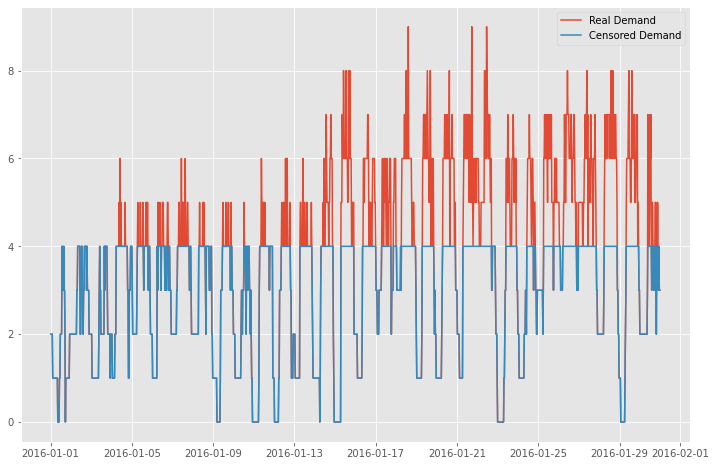

In [31]:

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))

#df_sample = df.WEBSTER[((df.index > '2016-01-01') & (df.index < '2016-01-31'))].copy()

df_sample = df[['WEBSTER','Day', 'Hour']][((df.index > '2016-01-01') & (df.index < '2016-01-31'))].copy()
df_sample = df_sample.rename(columns = {'WEBSTER': 'Sessions'}).reset_index()
df_sample['Censored'] = df_sample['Sessions'].values

df_sample.loc[df_sample.Sessions > 4, 'Censored'] = 4
df_sample.reset_index(drop=True, inplace=True)
plt.plot(df_sample.Period, df_sample.Sessions, label='Real Demand')
plt.plot(df_sample.Period, df_sample.Censored, label='Censored Demand')
plt.legend()
plt.show()

In [39]:
import torch.nn as nn
import torch
import numpy as np

In [40]:
input_dim = 48*7
output_dim = 48
hidden_dim = 100

In [41]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    # Calculate MSE and report it
    mse = nn.functional.mse_loss(y_predict, y)

    return mse.data.item()


In [42]:
def poisson_negative_log_likelihood(y_predict, y):
    """ https://en.wikipedia.org/wiki/Poisson_regression#Maximum_likelihood-based_parameter_estimation """
    return -torch.sum(y*y_predict - torch.exp(y_predict))

Epoch: 0 Loss: 1.0421601152420044
Epoch: 50 Loss: 0.9462449842153813
Epoch: 100 Loss: 0.9251650726866014
Epoch: 150 Loss: 0.9187415256847609
Epoch: 200 Loss: 0.9146761551947143


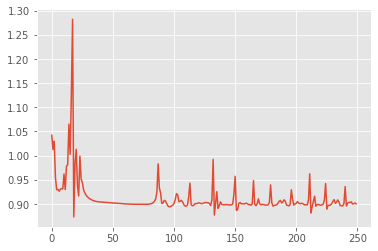

In [84]:
epochs = 250
model = AR_Net(input_dim, output_dim, 256)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = poisson_negative_log_likelihood
losses = []
model.train()
for epoch in range(epochs):
    loss_sum = 0
    for i in range((len(df_sample)-input_dim)//output_dim):
        X_train = torch.tensor(df_sample.iloc[output_dim*i: input_dim + output_dim * i].Sessions.values, dtype=torch.float32).view(1, -1)
        y_train = torch.tensor(df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim].Sessions.values, dtype=torch.float32).view(1, -1)
        loss_sum += train_batch(model, X_train, y_train, optimizer, loss_fn)
    losses.append(loss_sum/epochs)
    if (epoch % 50 == 0 ):
        print(f'Epoch: {epoch} Loss: {np.mean(losses)}')
plt.plot(losses)




In [85]:
# make prediction
X_eval = df_sample.reset_index(drop=True).iloc[:input_dim]
y_eval = df_sample.reset_index(drop=True).iloc[input_dim:input_dim + output_dim]

model.eval()
y_predict = model.forward(torch.tensor(X_eval.Sessions.values, dtype=torch.float32).view(1, -1))
y_predict = y_predict.detach().numpy().reshape(-1)

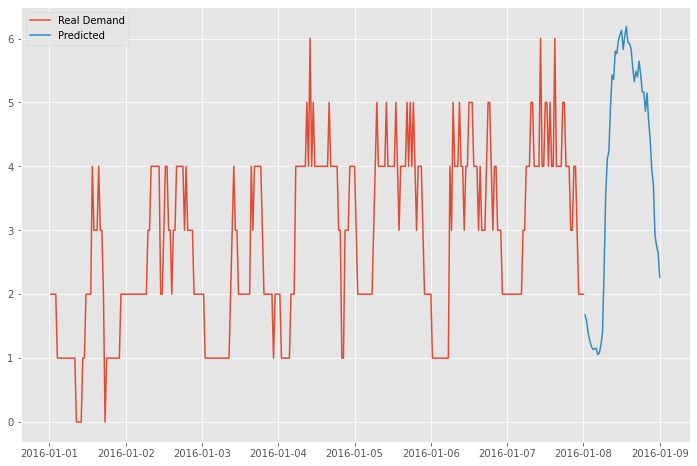

In [86]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_eval.Period, X_eval.Sessions.values, label='Real Demand')
ax.plot(y_eval.Period, np.exp(y_predict), label='Predicted')
plt.legend()

## Predicing using covariates (hour and week variable) at time t 

In [75]:
input_dim = 48*7
no_input_param = 3

output_dim = 48
hidden_dim = 100

In [90]:
epochs = 250
model = AR_Net_multi(input_dim, output_dim, 256)
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
#loss_fn = poisson_negative_log_likelihood
loss_fn = nn.MSELoss()
losses = []
model.train()
for epoch in range(epochs):
    loss_sum = 0
    for i in range((len(df_sample)-input_dim)//output_dim):
        X_train = torch.tensor(df_sample.iloc[output_dim*5: input_dim + output_dim * 5][['Sessions','Day', 'Hour']].values, dtype=torch.float32).reshape((no_input_param,336))
        y_train = torch.tensor(df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim].Sessions.values, dtype=torch.float32).view(1, -1)
        loss_sum += train_batch(model, X_train, y_train, optimizer, loss_fn)
    
    losses.append(loss_sum/epochs)

    if (epoch % 50 == 0 ):
        print(f'Epoch: {epoch} Loss: {np.mean(losses)}')
    
plt.plot(losses)
plt.show()

NameError: name 'AR_Net_multi' is not defined

In [80]:
# make prediction
X_eval = df_sample.reset_index(drop=True).iloc[:input_dim]
y_eval = df_sample.reset_index(drop=True).iloc[input_dim:input_dim + output_dim]

model.eval()
y_predict = model.forward(torch.tensor(X_eval.Sessions.values, dtype=torch.float32).view(1, -1))
y_predict = y_predict.detach().numpy().reshape(-1)

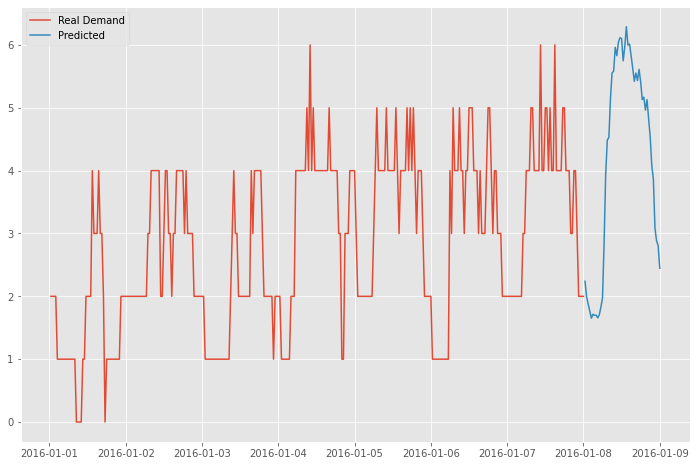

In [82]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_eval.Period, X_eval.Sessions.values, label='Real Demand')
#ax.plot(y_eval.Period, np.exp(y_predict), label='Predicted')
ax.plot(y_eval.Period, y_predict, label='Predicted')
plt.legend()

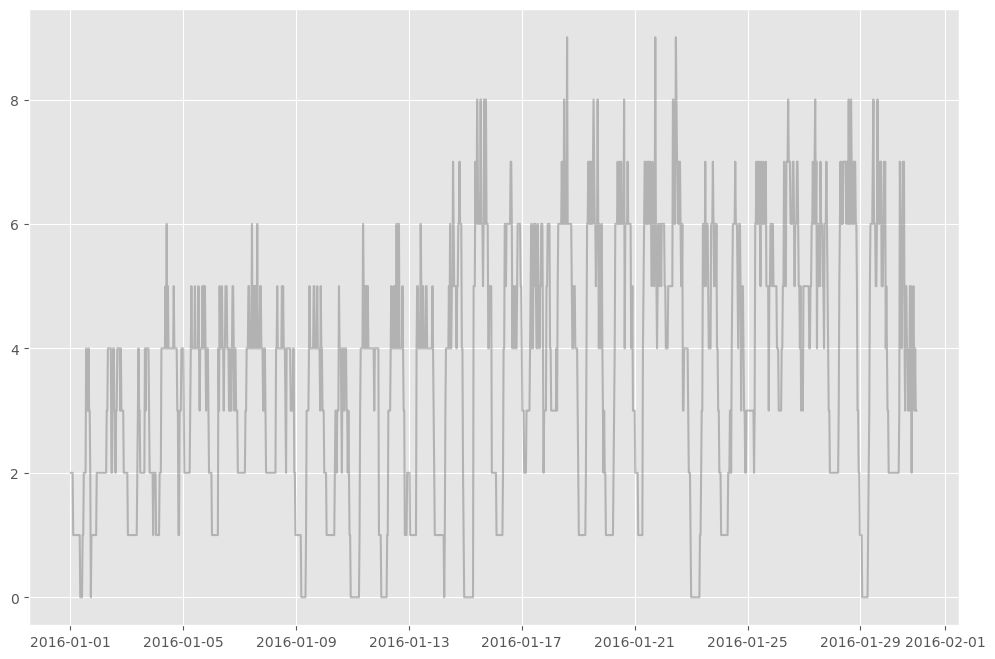

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [43]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand', color='grey', alpha=0.5)
plt.show()
for i in range((len(df_sample)-input_dim)//output_dim):
   X_train = df_sample.iloc[output_dim*i: input_dim + output_dim * i]
   y_train = df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim]
   line1, = ax.plot(X_train.Period, X_train.Sessions.values, label=f'{i}', color='red', alpha=0.5)
   line2, = ax.plot(y_train.Period, y_train.Sessions.values, label=f'{i}', color='green', alpha=0.5)

   plt.draw()
   plt.pause(1)
   line1.remove()
   line2.remove()

Cluster,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA,TED,WEBSTER
Period,,,,,,,,
2011-07-29 20:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 20:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 21:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 21:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 22:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2020-07-05 12:30:00,0.0,9.0,0.0,1.0,0.0,0.0,0.0,1.0
2020-07-05 13:00:00,0.0,6.0,0.0,1.0,1.0,1.0,0.0,1.0
2020-07-05 13:30:00,0.0,4.0,0.0,1.0,1.0,1.0,1.0,2.0


In [ ]:
# find the latest Period for each cluster


Timestamp('2020-07-05 14:30:00')

In [3]:
train_start = '2011-01-01 00:00:00'
train_end = '2014-08-31 23:00:00'
test_start = '2014-08-25 00:00:00' #need additional 7 days as given info (??)
test_end = '2014-09-07 23:00:00'
from dataloader import generate_covariates

covariates = generate_covariates(df[train_start:test_end].index, 4)
train_data = df[train_start:train_end].values
test_data = df[test_start:test_end].values

data_start = (train_data!=0).argmax(axis=0) #find first nonzero value in each time series
total_time = df.shape[0] 
num_series = df.shape[1] 

In [5]:
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset, Sampler

class TrainDataset(Dataset):
    def __init__(self, data_path, data_name):
        self.data = np.load(os.path.join(data_path, f'train_data_{data_name}.npy'))
        self.label = np.load(os.path.join(data_path, f'train_label_{data_name}.npy'))
        self.train_len = self.data.shape[0]

    def __len__(self):
        return self.train_len

    def __getitem__(self, index):
        return (self.data[index,:,:-1],int(self.data[index,0,-1]), self.label[index])

In [6]:
train_set = TrainDataset('', 'count')
train_loader = DataLoader(train_set, batch_size=32)


In [7]:
for i, (train_batch, idx, labels_batch) in enumerate(train_loader):
    print(train_batch, idx.shape, labels_batch)
    break


tensor([[[ 0.0000, -1.7320,  0.0000, 15.0000, 10.0000],
         [ 0.4627, -1.7320,  0.0000, 15.0000, 10.0000],
         [ 0.0000, -1.7320,  0.0000, 16.0000, 10.0000],
         ...,
         [ 0.4627, -1.7245,  0.0000, 13.0000, 10.0000],
         [ 0.9254, -1.7245,  0.0000, 14.0000, 10.0000],
         [ 0.9254, -1.7245,  0.0000, 14.0000, 10.0000]],

        [[ 0.0000, -1.7310,  1.0000, 15.0000, 10.0000],
         [ 0.0000, -1.7309,  1.0000, 15.0000, 10.0000],
         [ 0.4538, -1.7309,  1.0000, 16.0000, 10.0000],
         ...,
         [ 0.0000, -1.7234,  1.0000, 13.0000, 10.0000],
         [ 0.4538, -1.7234,  1.0000, 14.0000, 10.0000],
         [ 0.4538, -1.7234,  1.0000, 14.0000, 10.0000]],

        [[ 0.0000, -1.7299,  2.0000, 15.0000, 10.0000],
         [ 0.4375, -1.7298,  2.0000, 15.0000, 10.0000],
         [ 0.4375, -1.7298,  2.0000, 16.0000, 10.0000],
         ...,
         [ 0.0000, -1.7223,  2.0000, 13.0000, 10.0000],
         [ 0.0000, -1.7223,  2.0000, 14.0000, 10.0000],
  

In [11]:
df.T

Period,2011-07-29 20:00:00,2011-07-29 20:30:00,2011-07-29 21:00:00,2011-07-29 21:30:00,2011-07-29 22:00:00,2011-07-29 22:30:00,2011-07-29 23:00:00,2011-07-29 23:30:00,2011-07-30 00:00:00,2011-07-30 00:30:00,...,2020-07-05 10:00:00,2020-07-05 10:30:00,2020-07-05 11:00:00,2020-07-05 11:30:00,2020-07-05 12:00:00,2020-07-05 12:30:00,2020-07-05 13:00:00,2020-07-05 13:30:00,2020-07-05 14:00:00,2020-07-05 14:30:00
BRYANT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMBRIDGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,7.0,9.0,10.0,10.0,9.0,6.0,4.0,3.0,3.0
HAMILTON,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HIGH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0
MPL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
RINCONADA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
TED,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
WEBSTER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
